# Dense Sentiment Classifier

We're going to classify IMDB reviews by their sentiment.

<br>

<br>

## Load dependencies

In [1]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score, roc_curve, auc
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline

<br>

<br>

## Set hyperparameters

In [2]:
# Vector space embedding hyperparameters
n_dim = 64
n_unique_words = 5000  
n_words_to_skip = 50  
max_review_length = 100 
pad_type = trunc_type = 'pre' 

# Neural Network Architecture
dropout = 0.5 
epochs = 10
batch_size = 128

<br>

#### Observation
- **<em>Vector space embedding hyperparameters</em>**
    - **n_dim:** Number of dimensions that each word would take.
    - **n_unique_words:** Number for unique words 
    - **n_words_to_skip:** Skip the top N most frequently occurring words 
    - **max_review_length:** If our review has more than for example 100 words, we're going to truncate the review. We need, all our reviews have the same length. The longer the review, the greater the dimensionality the model we are fitting and the longer it take s to train.
    - **pad_type = trunc_type:** `pad_type` means, if our review is shorther than 100 words, we add the padding to the beggining and `trunc_type` means that if our review is longer than 100 words we truncate the beginning. This means that we are focusing on the ends of the reviews. It's another hyperparameter that we can tune whether it's better to focus on the begining of the review or on the end of the reviews. 
   
<br>

<br>

In [3]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words= n_unique_words, 
                                                                       skip_top=n_words_to_skip)

(x_train_all, _),(x_test_all, _) = tf.keras.datasets.imdb.load_data()                                                                      

#### Observation 
- In order to have access to the review aith all the words we read IMDB dataset again.

<br>


In [4]:
print(x_train.shape)
print(x_test.shape)

(25000,)
(25000,)


In [5]:
print(x_train[6])

[2, 2, 365, 1234, 2, 1156, 354, 2, 2, 2, 2, 2, 1016, 2, 2, 356, 2, 2, 1349, 500, 746, 2, 200, 2, 4132, 2, 2, 2, 1117, 1831, 2, 2, 4831, 2, 2, 2, 4183, 2, 369, 2, 215, 1345, 143, 2, 2, 1838, 2, 1974, 2, 2, 119, 257, 85, 52, 486, 2, 2, 2, 2, 63, 271, 2, 196, 96, 949, 4121, 2, 2, 2, 2, 2212, 2436, 819, 63, 2, 77, 2, 180, 2, 227, 2, 94, 2494, 2, 2, 423, 2, 168, 2, 2, 2, 2, 89, 665, 71, 270, 56, 2, 2, 197, 2, 161, 2, 99, 76, 2, 2, 2, 419, 665, 2, 91, 85, 108, 2, 2, 2084, 2, 4773, 81, 55, 52, 1901]


<br>

#### Observation
- 0: Reserved for padding. So, if we had short review, then it will be padded with zeros as placeholder words. 
- 1: Starting character.
- 2: Unknown characters 
- 3: Word that occurs most often in the dataset, 
- 4: Represents the second most often word, and so on , all the way through to the 5000 words that we have in our dataset.

<br>

#### Let's decode one of the sentences to see what it looks like.

In [6]:
# a mapping from words to their indices, for example `human`: 403
word_index = tf.keras.datasets.imdb.get_word_index()

# create the reverse mapping i.e. from indices to words
rev_word_index = {idx:w for w,idx in word_index.items()}

def decode_sentence(s):
    # index 0 to 2 are reserved for things like padding, unknown word, etc.
    decoded_sent = [rev_word_index.get(idx-3, '[RES]') for idx in s]
    return ' '.join(decoded_sent)

In [7]:
# [decode_sentence(x_train_all[cnt]) for cnt in range(3)]
[decode_sentence(x_train[cnt]) for cnt in range(3)]

["[RES] [RES] [RES] [RES] [RES] brilliant casting location scenery story direction everyone's really suited [RES] part [RES] played [RES] [RES] could [RES] imagine being there robert [RES] [RES] [RES] amazing actor [RES] now [RES] same being director [RES] father came [RES] [RES] same scottish island [RES] myself [RES] [RES] loved [RES] fact there [RES] [RES] real connection [RES] [RES] [RES] [RES] witty remarks throughout [RES] [RES] were great [RES] [RES] [RES] brilliant [RES] much [RES] [RES] bought [RES] [RES] [RES] soon [RES] [RES] [RES] released [RES] [RES] [RES] would recommend [RES] [RES] everyone [RES] watch [RES] [RES] fly [RES] [RES] amazing really cried [RES] [RES] end [RES] [RES] [RES] sad [RES] [RES] know what [RES] say [RES] [RES] cry [RES] [RES] [RES] [RES] must [RES] been good [RES] [RES] definitely [RES] also [RES] [RES] [RES] two little [RES] [RES] played [RES] [RES] [RES] norman [RES] paul [RES] were [RES] brilliant children [RES] often left [RES] [RES] [RES] [RES] 

In [8]:
y_train[:10]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0])

<br>

#### Observation
- 1: Positive
- 0: Negative

<br>

In [9]:
for cnt in range(5):
    print(len(x_train[cnt]))

218
189
141
550
147


<br>

#### Observation
- Reviews are in different lengths. For our training they should be in the same length.

<br>

<br>

## Data preprocessing 

In [10]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, 
                                                        maxlen=max_review_length, 
                                                        padding=pad_type, 
                                                        truncating=trunc_type, 
                                                        value=0)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, 
                                                       maxlen=max_review_length, 
                                                       padding=pad_type, 
                                                       truncating=trunc_type, 
                                                       value=0)

<br>

#### Observation
- **maxlen=max_review_length=100**    
    - If our review has more than 100 words, we're going to truncate the review. We need all our review have the same length. The longer the review, the greater the dimensionality the model we are fitting and the longer it take s to train.
    
    
- **padding=pad_type, truncating=trunc_type**
    - *pad_type* : if our review is shorther than 100 words, we add the padding to the beggining and 
    - *trunc_type* : if our review is longer than 100 words we truncate the beginning. 
    
    
- **value = 0**: Use the value of 0 for our padding

<br>

In [11]:
for cnt in range(5):
    print(len(x_train[cnt]))

100
100
100
100
100


<br>

#### Observation
- They all are in the same length

<br>

<br>

In [12]:
print(decode_sentence(x_train[5]))
print('-'*126)
print(x_train[5])

[RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] [RES] begins better than [RES] ends funny [RES] [RES] russian [RES] crew [RES] [RES] other actors [RES] [RES] those scenes where documentary shots [RES] [RES] spoiler part [RES] message [RES] [RES] contrary [RES] [RES] whole story [RES] [RES] does [RES] [RES] [RES] [RES]
------------------------------------------------------------------------------------------------------------------------------
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0 

<br>

<br>

## ANN architecture 

In [13]:
model = tf.keras.models.Sequential()


# Embedding Layer(Taking Inputs)
model.add(tf.keras.layers.Embedding(input_dim=n_unique_words, 
                                    output_dim=n_dim, 
                                    input_length=max_review_length))

# Flattening
model.add(tf.keras.layers.Flatten()) 


# Dense Fully Connected Layer
model.add(tf.keras.layers.Dense(units=128, 
                                activation='relu')) 
model.add(tf.keras.layers.Dropout(0.5)) 
model.add(tf.keras.layers.Dense(units=64, 
                                activation='relu')) 
model.add(tf.keras.layers.Dropout(0.5)) 


# Output Layer
model.add(tf.keras.layers.Dense(units=1, 
                                activation='sigmoid'))  

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           320000    
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               819328    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6

In [15]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [16]:
history = model.fit(x_train, 
                    y_train, 
                    batch_size=32, 
                    epochs=10,                     
                    validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 8s 356us/sample - loss: 0.4879 - accuracy: 0.7406 - val_loss: 0.3563 - val_accuracy: 0.8428
Epoch 2/10
22500/22500 [==============================] - 7s 321us/sample - loss: 0.2228 - accuracy: 0.9154 - val_loss: 0.4153 - val_accuracy: 0.8352
Epoch 3/10
22500/22500 [==============================] - 7s 320us/sample - loss: 0.0485 - accuracy: 0.9845 - val_loss: 0.7227 - val_accuracy: 0.8276
Epoch 4/10
22500/22500 [==============================] - 7s 326us/sample - loss: 0.0190 - accuracy: 0.9929 - val_loss: 1.0320 - val_accuracy: 0.8120
Epoch 5/10
22500/22500 [==============================] - 7s 329us/sample - loss: 0.0187 - accuracy: 0.9937 - val_loss: 1.0780 - val_accuracy: 0.8176
Epoch 6/10
22500/22500 [==============================] - 7s 326us/sample - loss: 0.0147 - accuracy: 0.9953 - val_loss: 1.0346 - val_accuracy: 0.8168
Epoch 7/10
22500/22500 [===========================

<br>

<br>

## Plotting the accuracy

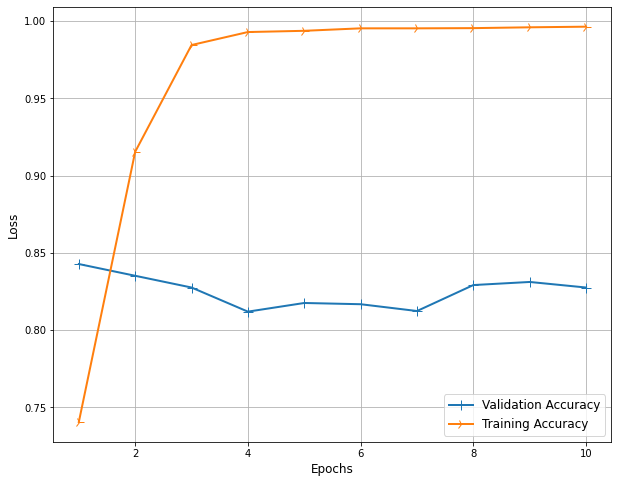

In [17]:
plt.figure(figsize=(10,8))
history_dict = history.history   

loss_values = history_dict['accuracy']
val_loss_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation Accuracy')
line2 = plt.plot(epochs, loss_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs', fontsize=12) 
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.show()

In [18]:
score = model.evaluate(x_test, 
                       y_test)

print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

25000/25000 [==============================] - 1s 42us/sample - loss: 1.2147 - accuracy: 0.8088

Test loss: 1.2147236950540543
Test accuracy: 0.80884


In [19]:
y_hat = model.predict_proba(x_test)

In [20]:
# It assign this number as the probability that it's a positive review
print(f'Probability that y_hat[0] is a positive review: {y_hat[0]}')


print(f'The original review: {y_test[0]}\n')

Probability that y_hat[0] is a positive review: [0.29822785]
The original review: 0



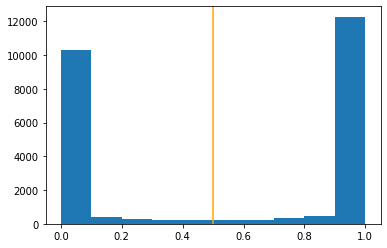

In [21]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

<br>

<br>

## Visualization using AUC

AUC: 89.55




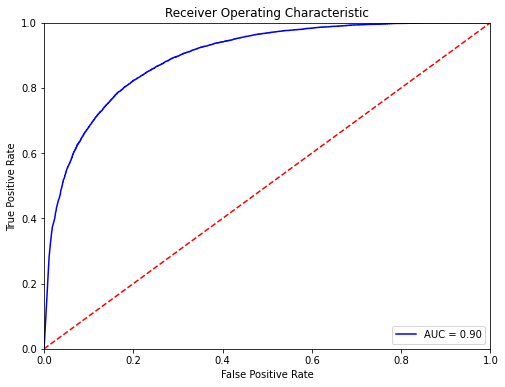

In [22]:
plt.figure(figsize=(8,6))

pct_auc = roc_auc_score(y_test, y_hat)*100.0
print(f'AUC: {pct_auc:0.2f}\n\n')

fpr, tpr, threshold = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc:0.2f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Observation
- **AUC ROC**
    - A simple way of evaluating model performance is through the cost, so on the validation dataset we want to get the lowest cost as we could get, but that does not translate mush in the real world. Another simple metric for measuring the performance of a statistical model is the accuracy. So, for example for the movie reviews, if the probability output for a given review is above 0.5 out of 1, we can say, that is our threshold and it’s a positive review. However, that kind of single threshold at the middle is simplistic as well. It would be nice to know that a prediction that typically of 0.1 is less likely to be a positive review.  Something close to 0.3 is not as negative as to 0.1, something at 0.5 is right at the middle. For example, if the only metric we consider is accuracy, then a review that is assign to score of 0.49 is bare different from a review of 0.51, yet we are saying 0.49 is negative and 0.51 is positive. It does not seem nuance or noticeable. 
    - A different complex metric is the area under the curve of the receiver operating characteristic. It’s a single value that represents a model’s performance across the whole range of output from 0 up to 1.
 


<br>

<br>

## Examining the model performance

In [23]:
pd.options.display.float_format = '{:.5f}'.format

y_hat = model.predict_proba(x_test)

float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])
    
ydf = pd.DataFrame(list(zip(float_y_hat, y_test)), columns=['y_hat', 'y'])
ydf['y_hat'] = ydf['y_hat'].astype('float32') 

ydf.head(10)

,y_hat,y
0,0.29823,0
1,1.00000,1
2,0.99409,1
3,0.02987,0
4,1.00000,1
5,0.99986,1
6,1.00000,1
7,0.00000,0
8,0.99999,0
9,1.00000,1


<br>

<br>

### Negative reviews that were assigned positive

In [24]:
mask = (ydf['y'] == 0) & (ydf['y_hat'] > 0.9)
print(f'\nNumber of negative reviews that were assigned positive: {len(ydf[mask])}\n')
ydf[mask].head()


Number of negative reviews that were assigned positive: 2244



,y_hat,y
8,0.99999,0
17,0.99814,0
38,0.94300,0
59,0.92402,0
66,0.99024,0


In [25]:
print(decode_sentence(x_test_all[8]))
print()
print(decode_sentence(x_test[8]))

[RES] hollywood had a long love affair with bogus arabian nights tales but few of these products have stood the test of time the most memorable were the jon hall maria montez films which have long since become camp this one is filled with dubbed songs anachronistic slang and slapstick it's a truly crop of corn and pretty near intolerable today it was nominated for its imaginative special effects which are almost unnoticeable in this day and age consisting mainly of trick photography the only outstanding positive feature which survives is its beautiful color and clarity sad to say of the many films made in this genre few of them come up to alexander korda's original thief of baghdad almost any other arabian nights film is superior to this one though it's a loser

[RES] long since become camp [RES] [RES] [RES] filled [RES] dubbed songs [RES] [RES] [RES] slapstick [RES] [RES] truly [RES] [RES] [RES] [RES] pretty near [RES] today [RES] [RES] nominated [RES] its imaginative special effects 

<br>

<br>

### Positive reviews that were assigned negative

In [26]:
mask = (ydf['y'] == 1) & (ydf['y_hat'] < 0.1)
print(f'\nNumber of positive reviews that were assigned negative: {len(ydf[mask])}\n')

ydf[mask].head()


Number of positive reviews that were assigned negative: 1363



,y_hat,y
22,0.03152,1
45,0.04812,1
49,0.03422,1
53,0.08467,1
72,0.09391,1


<br>

---

<br>

<br>

# Convolutional Sentiment Classifier

- Classify IMDB reviews by their sentiment with a ConvNet

- we use CNN for machine vision to detect features like a particular orientation of an edge wherever occurs in an image. In an image our data is 2-dimensions, however in NLP our data is linear and just in a single dimension, so our convolution will be linear in 1 dimension.


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc

%matplotlib inline

<br>

## Load data

In [2]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=5000) # 5000 is the number of unique words

<br>

<br>

## Preprocess data 

In [3]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, 
                                                        maxlen=400, 
                                                        padding='pre', 
                                                        truncating='pre', 
                                                        value=0)


x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, 
                                                       maxlen=400, 
                                                       padding='pre', 
                                                       truncating='pre', 
                                                       value=0)

<br>

<br>

## CNN architecture

In [4]:
model = tf.keras.models.Sequential()

# Embedding Layer(Taking Inputs) 
model.add(tf.keras.layers.Embedding(input_dim=5000,
                                    output_dim=64, 
                                    input_length=400))
model.add(tf.keras.layers.SpatialDropout1D(0.2)) # dropout out for embedding layer


# CNN Layer 
model.add(tf.keras.layers.Conv1D(filters=256,
                                 kernel_size=3, 
                                 activation='relu'))
model.add(tf.keras.layers.GlobalMaxPool1D()) 


# Dense Layer 
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))


# Output Layer 
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid')) 

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 64)           320000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 400, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 398, 256)          49408     
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

In [6]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [7]:
history = model.fit(x_train, 
                    y_train, 
                    batch_size=128,
                    epochs=10, 
                    validation_split=.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 31s 1ms/sample - loss: 0.5029 - accuracy: 0.7280 - val_loss: 0.3254 - val_accuracy: 0.8580
Epoch 2/10
22500/22500 [==============================] - 29s 1ms/sample - loss: 0.2584 - accuracy: 0.8929 - val_loss: 0.2677 - val_accuracy: 0.8924
Epoch 3/10
22500/22500 [==============================] - 30s 1ms/sample - loss: 0.1789 - accuracy: 0.9322 - val_loss: 0.2682 - val_accuracy: 0.8928
Epoch 4/10
22500/22500 [==============================] - 30s 1ms/sample - loss: 0.1161 - accuracy: 0.9597 - val_loss: 0.2971 - val_accuracy: 0.8888
Epoch 5/10
22500/22500 [==============================] - 30s 1ms/sample - loss: 0.0754 - accuracy: 0.9761 - val_loss: 0.3296 - val_accuracy: 0.8964
Epoch 6/10
22500/22500 [==============================] - 30s 1ms/sample - loss: 0.0414 - accuracy: 0.9882 - val_loss: 0.3776 - val_accuracy: 0.8884
Epoch 7/10
22500/22500 [==============================] -

<br>

<br>

## Plotting the accuracy 

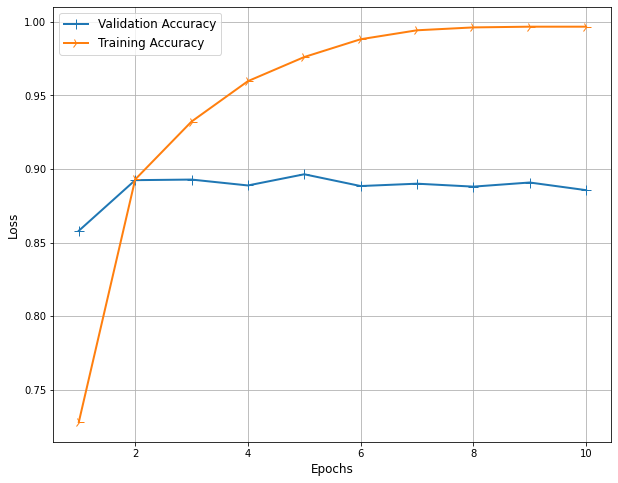

In [8]:
plt.figure(figsize=(10,8))
history_dict = history.history   

loss_values = history_dict['accuracy']
val_loss_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation Accuracy')
line2 = plt.plot(epochs, loss_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs', fontsize=12) 
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.show()

In [9]:
score = model.evaluate(x_test,
                       y_test)

print(f'Test Loss: {score[0]}')
print(f'Test Accuracy: {score[1]}')

25000/25000 [==============================] - 7s 288us/sample - loss: 0.5404 - accuracy: 0.8808
Test Loss: 0.5403802647086233
Test Accuracy: 0.880840003490448


<br>

<br>

## Examining the model performance

In [10]:
pd.options.display.float_format = '{:.5f}'.format

y_hat = model.predict_proba(x_test)

float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])
    
ydf = pd.DataFrame(list(zip(float_y_hat, y_test)), columns=['y_hat', 'y'])
ydf['y_hat'] = ydf['y_hat'].astype('float32') 

ydf.head(10)

,y_hat,y
0,0.00035,0
1,0.99990,1
2,0.98523,1
3,0.98357,0
4,1.00000,1
5,0.87010,1
6,0.99965,1
7,0.00000,0
8,0.99999,0
9,0.99899,1


<br>

<br>

### Negative reviews that were assigned positive

In [11]:
mask = (ydf['y'] == 0) & (ydf['y_hat'] > 0.9)
print(f'\nNumber of negative reviews that were assigned positive: {len(ydf[mask])}\n')
ydf[mask].head()


Number of negative reviews that were assigned positive: 865



,y_hat,y
3,0.98357,0
8,0.99999,0
13,0.99839,0
17,0.95009,0
81,0.96939,0


<br>

<br>

### Positive reviews that were assigned negative

In [12]:
mask = (ydf['y'] == 1) & (ydf['y_hat'] < 0.1)
print(f'\nNumber of positive reviews that were assigned negative: {len(ydf[mask])}\n')

ydf[mask].head()


Number of positive reviews that were assigned negative: 1104



,y_hat,y
24,0.00007,1
31,0.01455,1
55,0.00211,1
82,0.00029,1
87,0.01683,1


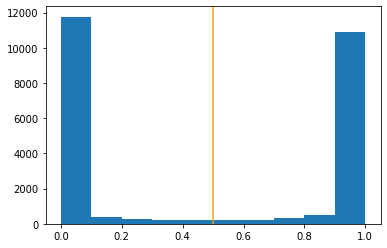

In [13]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')


<br>

<br>

## Visualization using AUC

AUC: 95.23




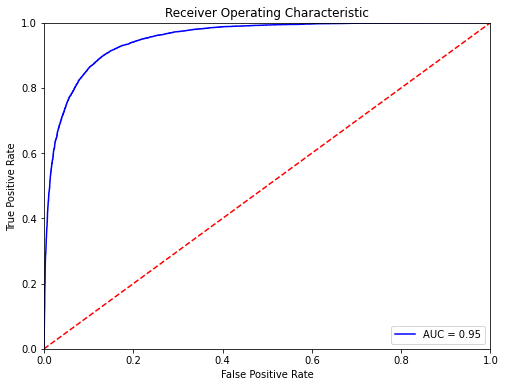

In [14]:
pct_auc = roc_auc_score(y_test, y_hat)*100.0
print(f'AUC: {pct_auc:0.2f}\n\n')

plt.figure(figsize=(8,6))

fpr, tpr, threshold = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc:0.2f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<br>

---

<br>